In [12]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [13]:
#Get the stock quote 
#df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 
df = pd.read_csv("NBL.txt")
#Show the data 
df

,Date,Open,High,Low,Close,Volume
0,2016-02-01,321,327,322,321,31428
1,2016-02-02,325,332,321,325,32366
2,2016-02-03,328,335,326,328,47110
3,2016-02-04,330,333,326,330,27469
4,2016-02-07,330,342,328,330,41078
...,...,...,...,...,...,...
945,2020-02-09,270,271,267,270,60188
946,2020-02-10,269,273,267,269,41674
947,2020-02-11,269,275,268,269,66521
948,2020-02-12,269,271,267,269,105904


In [14]:
df.shape

(950, 6)

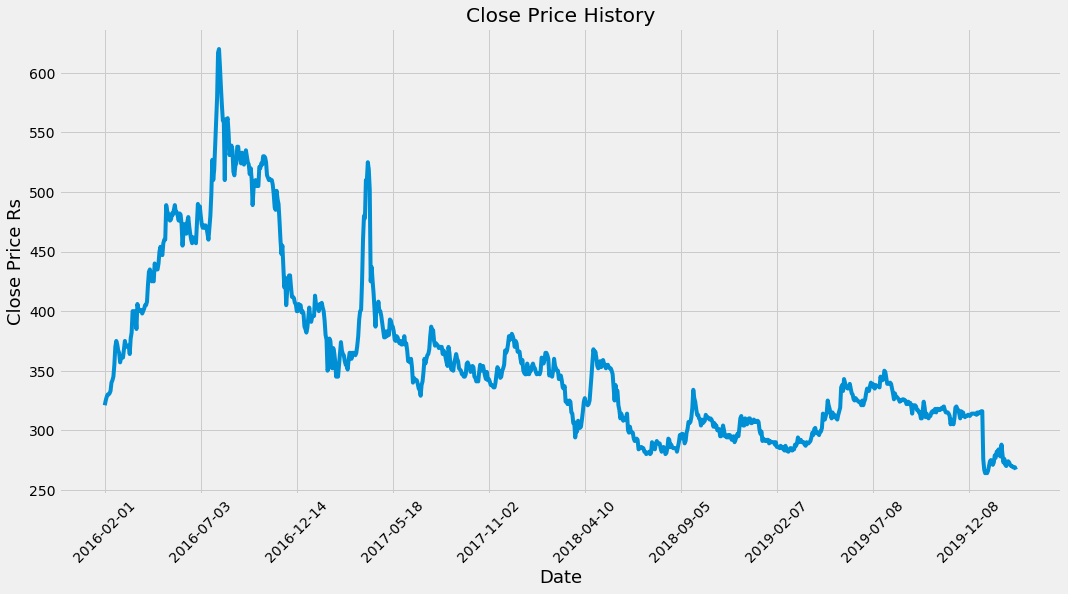

In [15]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price Rs',fontsize=18)
plt.show()

In [16]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [17]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [18]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [19]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [21]:
x_train.shape

(700, 60, 1)

In [22]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [23]:
import tensorflow as tf
import keras

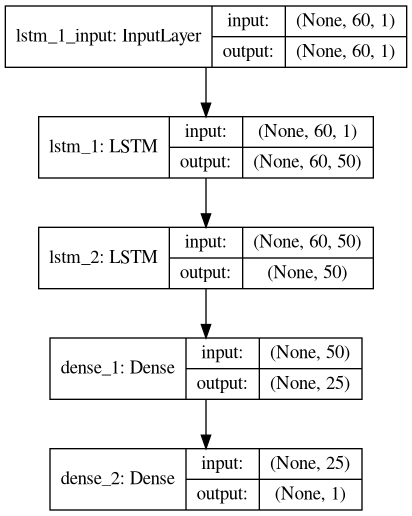

In [24]:
keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [25]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
700/700 [==============================] - 117s 167ms/step - loss: 0.0047


In [16]:
model.save('NBL_LSTM_new_1bz_1epoc.h5')

In [26]:
model = load_model('NBL_LSTM_new_1bz_1epoc.h5')

In [27]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [28]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [29]:
x_test.shape

(190, 60)

In [30]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [31]:
x_test.shape

(190, 60, 1)

In [32]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [33]:
#mean absolute percentage error
MAPE = np.mean(np.abs((y_test - predictions) / y_test)) * 100
MAPE

2.1555570251913743

In [34]:
ax = None
mse = np.mean((y_test-predictions)**2)
mse

84.5013836105207

In [35]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

9.19246341360795

/home/joyboy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


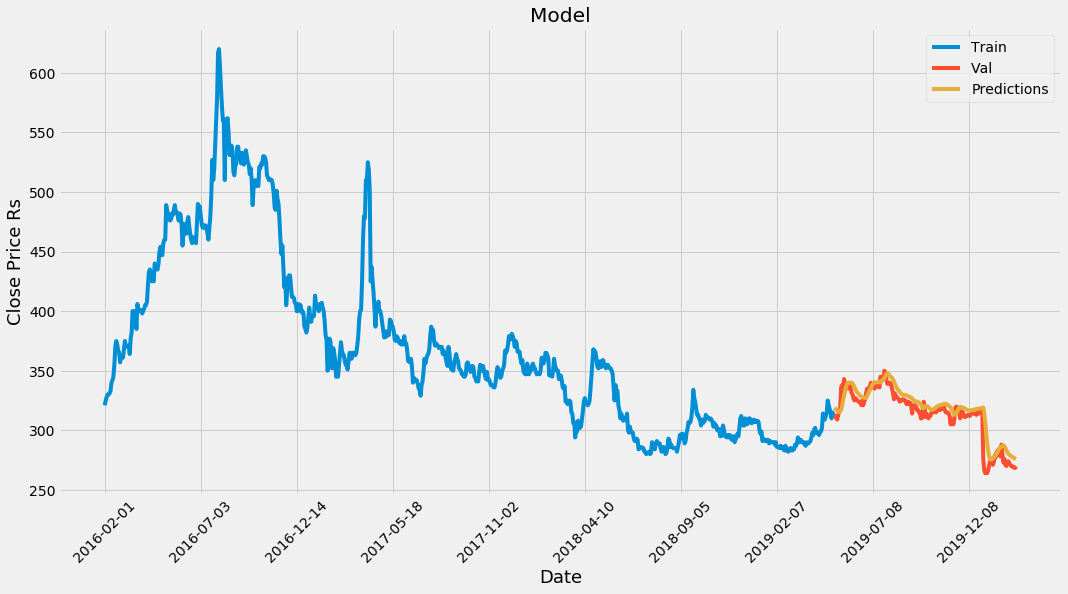

In [36]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price Rs', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [37]:
valid

,Close,Predictions
760,313,318.763458
761,312,318.013794
762,310,317.346527
763,309,316.570221
764,313,315.723297
...,...,...
945,270,277.901764
946,269,277.338654
947,269,276.751648
948,269,276.226105


In [38]:
from datetime import date, timedelta


def predict_stock(input_date): 
    with open('NBL.txt', 'r') as f:
        lines = f.read().splitlines()
        last_line = lines[-1]
        x = int(last_line[:4])
        y = int(last_line[5:7])
        z = int(last_line[8:10])
    ldate = date(x, y, z)
    delta = input_date - ldate
    date_close_df = df.filter(['Date'] + ['Close'])
    
    for i in range(delta.days):
        #Create a new dataframe
        new_df = date_close_df.filter(['Close'])
        #Get teh last 60 day closing price 
        last_60_days = new_df[-60:].values
        #Scale the data to be values between 0 and 1
        last_60_days_scaled = scaler.transform(last_60_days)
        #Create an empty list
        X_test = []
        #Append teh past 60 days
        X_test.append(last_60_days_scaled)
        #Convert the X_test data set to a numpy array
        X_test = np.array(X_test)
        #Reshape the data
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        #Get the predicted scaled price
        pred_price = model.predict(X_test)
        #undo the scaling 
        pred_price = scaler.inverse_transform(pred_price)
        #print(int(pred_price))
        
        new_day = ldate + timedelta(days=i+1)
        #print(new_day)
        #print("\t")
        fd = pd.DataFrame([[new_day, int(pred_price)]], columns=('Date','Close'))
        print(fd)
        date_close_df = date_close_df.append(fd, ignore_index=True)
    return(date_close_df)

print("Enter the date to be predicted")
#input_date = date(2020,3,20)
#input_date = input()
year = int(input('Enter a year'))
month = int(input('Enter a month'))
day = int(input('Enter a day'))
input_date = date(year, month, day)
predict_stock(input_date)

Enter the date to be predicted


Enter a year 2020
Enter a month 3
Enter a day 20


         Date  Close
0  2020-02-14    275
         Date  Close
0  2020-02-15    275
         Date  Close
0  2020-02-16    276
         Date  Close
0  2020-02-17    277
         Date  Close
0  2020-02-18    278
         Date  Close
0  2020-02-19    280
         Date  Close
0  2020-02-20    281
         Date  Close
0  2020-02-21    282
         Date  Close
0  2020-02-22    283
         Date  Close
0  2020-02-23    285
         Date  Close
0  2020-02-24    286
         Date  Close
0  2020-02-25    287
         Date  Close
0  2020-02-26    288
         Date  Close
0  2020-02-27    289
         Date  Close
0  2020-02-28    290
         Date  Close
0  2020-02-29    291
         Date  Close
0  2020-03-01    292
         Date  Close
0  2020-03-02    293
         Date  Close
0  2020-03-03    294
         Date  Close
0  2020-03-04    295
         Date  Close
0  2020-03-05    296
         Date  Close
0  2020-03-06    297
         Date  Close
0  2020-03-07    298
         Date  Close
0  2020-03-08

,Date,Close
0,2016-02-01,321
1,2016-02-02,325
2,2016-02-03,328
3,2016-02-04,330
4,2016-02-07,330
...,...,...
981,2020-03-16,307
982,2020-03-17,308
983,2020-03-18,309
984,2020-03-19,310
